# YZV 202E Optimization for Data Science, Term Project

In [1]:
import functools
import numpy as np
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import scipy.special

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Basic MLP

We used this class in order to test our optimized weights.

In [2]:
class MultiLayerPerceptron:
    def __init__(self, shape, weights=None):
        self.shape = shape
        self.num_layers = len(shape)
        if weights is None:
            self.weights = []
            for i in range(self.num_layers - 1):
                W = np.random.uniform(size=(self.shape[i + 1], self.shape[i] + 1))
                self.weights.append(W)
        else:
            self.weights = weights

    def run(self, data):
        layer = data.T
        for i in range(self.num_layers - 1):
            prev_layer = layer
            o = np.dot(self.weights[i], prev_layer)
            # sigmoid
            layer = scipy.special.expit(o)
        return layer


### Util class and functions

Here Result class is used to get the results of optimization methods and help for plotting

In [3]:
class Result(object):
    def __init__(self, best_particle, best_scores, accuracies, num_iterations):
        self.best_particle = best_particle
        self.best_scores = best_scores
        self.accuracies = accuracies
        self.num_iterations = num_iterations

'eval_' functions are used to evaluate the results of current weights at each epoch

In [4]:
def eval_accuracy(weights, shape, X, y):
    corrects, wrongs = 0, 0
    nn = MultiLayerPerceptron(shape, weights=weights)
    predictions = []
    for i in range(len(X)):
        out_vector = nn.run(X[i])
        y_pred = np.argmax(out_vector)
        predictions.append(y_pred)
        if y_pred == y[i]:
            corrects += 1
        else:
            wrongs += 1
    return corrects, wrongs, predictions

def eval_neural_network_via_vector(weights, shape, X, y):
    mse = np.asarray([])
    weight = vector_to_weights(np.array(weights), shape)
    nn = MultiLayerPerceptron(shape, weights=weight)
    y_pred = nn.run(X)
    mse = np.append(mse, sklearn.metrics.mean_squared_error(np.atleast_2d(y), y_pred))
    return mse

def eval_neural_network_via_weights(weights, shape, X, y):
    mse = np.asarray([])
    for w in weights:
        weight = vector_to_weights(w, shape)
        nn = MultiLayerPerceptron(shape)
        nn.weights = weight
        y_pred = nn.run(X)
        mse = np.append(mse, sklearn.metrics.mean_squared_error(np.atleast_2d(y), y_pred))
    return mse

These functions are used for making every calculation easier in order of matrix multiplication etc.

In [5]:
def dim_weights(shape):
    dim = 0
    for i in range(len(shape) - 1):
        dim = dim + (shape[i] + 1) * shape[i + 1]
    return dim

def weights_to_vector(weights):
    w = np.asarray([])
    for i in range(len(weights) + 1):
        v = weights[i].flatten()
        w = np.append(w, v)
    return w


def vector_to_weights(vector, shape):
    weights = []
    idx = 0
    for i in range(len(shape) - 1):
        r = shape[i + 1]
        c = shape[i]
        idx_min = idx
        idx_max = idx + r * c
        W = vector[idx_min:idx_max].reshape((r, c))
        weights.append(W)
        idx = idx_max
    return weights

To print best current weights mse

In [6]:
def print_best(best_particle):
    print("New best weights found at iteration #{i} with mean squared error: {score}".format(i=best_particle[0], score=best_particle[1]))

## Gradient Methods:

### Gradient Descent MLP

Basic Gradient descent method implementation on MLP

In [7]:
# Multi-layer Perceptron with Gradient Descent
class MLPGradDescent:
    def __init__(self, shape, learning_rate=0.1, max_epochs=1000, print_epochs=True):
        self.shape = shape
        self.num_layers = len(shape)
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.print_epochs = print_epochs
        self.weights = []

    def initialize_weights(self):
        self.weights = []
        for i in range(self.num_layers - 1):
            W = np.random.uniform(size=(self.shape[i + 1], self.shape[i]))
            self.weights.append(W)

    def forward_propagation(self, X):
        activations = [X]
        for i in range(self.num_layers - 2):
            activation = scipy.special.expit(np.dot(activations[-1], self.weights[i]))
            activations.append(activation)

        output = scipy.special.expit(np.dot(activations[-1], self.weights[-1].T))
        activations.append(output)
        return activations

    def backward_propagation(self, X, y, activations):
        error = activations[-1] - y
        delta = error * activations[-1] * (1 - activations[-1])

        for i in range(self.num_layers - 2, 0, -1):
            self.weights[i] -= self.learning_rate * np.dot(delta.T, activations[i])
            hidden_error = np.dot(delta, self.weights[i])
            delta = hidden_error * activations[i] * (1 - activations[i])

        self.weights[0] -= self.learning_rate * np.dot(delta.T, X)

    def get_score(self, X, y):
        nn = MultiLayerPerceptron(self.shape, weights=self.weights)
        y_pred = nn.run(X)
        mse = sklearn.metrics.mean_squared_error(y, y_pred.T)
        return mse
    
    def train(self, X, y_oncecoded, y):
        self.initialize_weights()
        i = 0
        accuracies = []
        best_scores = [(i, 1)]
        if self.print_epochs:
            print_best(i, best_scores[-1])
        for epoch in range(self.max_epochs):
            activations = self.forward_propagation(X)
            self.backward_propagation(X, y_oncecoded, activations)
            i = i + 1
            score = self.get_score(X, y_oncecoded)
            corrects, wrongs, predictions = eval_accuracy(self.weights, self.shape, X, y)
            accuracy = corrects / (corrects + wrongs)
            best_scores.append((i, score))
            if self.print_epochs:
                print_best(i, best_scores[-1])
                print("With accuracy: {accuracy}".format(accuracy=accuracy))
            accuracies.append(accuracy)
        
        return Result(
            best_particle = self.weights,
            best_scores = best_scores,
            accuracies = accuracies,
            num_iterations = self.max_epochs
        )
        
    def predict(self, X):
        activations = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)

### Stochastic Gradient Descent MLP

Basic Stochastic Gradient descent method implementation on MLP

In [8]:
class MLPStochasticGradDescent:
    def __init__(self, shape, learning_rate=0.1, max_epochs=1000, batch_size=1, print_epochs=True):
        self.shape = shape
        self.num_layers = len(shape)
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.print_epochs = print_epochs
        self.weights = []

    def initialize_weights(self):
        self.weights = []
        for i in range(self.num_layers - 1):
            W = np.random.uniform(size=(self.shape[i + 1], self.shape[i]))
            self.weights.append(W)

    def forward_propagation(self, X):
        activations = [X]
        for i in range(self.num_layers - 2):
            activation = scipy.special.expit(np.dot(activations[-1], self.weights[i]))
            activations.append(activation)

        output = scipy.special.expit(np.dot(activations[-1], self.weights[-1].T))
        activations.append(output)
        return activations

    def backward_propagation(self, X, y, activations):
        error = activations[-1] - y
        delta = error * activations[-1] * (1 - activations[-1])

        for i in range(self.num_layers - 2, 0, -1):
            self.weights[i] -= self.learning_rate * np.dot(delta.T, activations[i])
            hidden_error = np.dot(delta, self.weights[i])
            delta = hidden_error * activations[i] * (1 - activations[i])

        self.weights[0] -= self.learning_rate * np.dot(delta.T, X)

    def get_score(self, X, y):
        nn = MultiLayerPerceptron(self.shape, weights=self.weights)
        y_pred = nn.run(X)
        mse = sklearn.metrics.mean_squared_error(y, y_pred.T)
        return mse

    def train(self, X, y_onehot, y):
        self.initialize_weights()
        i = 0
        accuracies = []
        best_scores = [(i, 1)]
        if self.print_epochs:
            print_best([i, best_scores[-1]])
        for epoch in range(self.max_epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_onehot_shuffled = y_onehot[indices]
            for j in range(0, X.shape[0], self.batch_size):
                X_batch = X_shuffled[j:j + self.batch_size]
                y_batch = y_onehot_shuffled[j:j + self.batch_size]
                activations = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, activations)
            i += 1

            score = self.get_score(X, y_onehot)
            corrects, wrongs, predictions = eval_accuracy(self.weights, self.shape, X, y)
            accuracy = corrects / (corrects + wrongs)
            best_scores.append((i, score))
            if self.print_epochs:
                print_best([i, best_scores[-1]])
                print("With accuracy: {accuracy}".format(accuracy=accuracy))
            accuracies.append(accuracy)

        return Result(
            best_particle=self.weights,
            best_scores=best_scores,
            accuracies=accuracies,
            num_iterations=self.max_epochs
        )

    def predict(self, X):
        activations = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)


### Batch Gradient Descent MLP

Basic Batch Gradient descent method implementation on MLP

In [9]:
import numpy as np
import scipy.special
import sklearn.metrics

class MLPBatchGradDescent:
    def __init__(self, shape, learning_rate=0.1, max_epochs=1000, print_epochs=True):
        self.shape = shape
        self.num_layers = len(shape)
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.print_epochs = print_epochs
        self.weights = []

    def initialize_weights(self):
        self.weights = []
        for i in range(self.num_layers - 1):
            W = np.random.uniform(size=(self.shape[i + 1], self.shape[i]))
            self.weights.append(W)

    def forward_propagation(self, X):
        activations = [X]
        for i in range(self.num_layers - 2):
            activation = scipy.special.expit(np.dot(activations[-1], self.weights[i]))
            activations.append(activation)

        output = scipy.special.expit(np.dot(activations[-1], self.weights[-1].T))
        activations.append(output)
        return activations

    def backward_propagation(self, X, y, activations):
        error = activations[-1] - y
        delta = error * activations[-1] * (1 - activations[-1])

        for i in range(self.num_layers - 2, 0, -1):
            self.weights[i] -= self.learning_rate * np.dot(delta.T, activations[i])
            hidden_error = np.dot(delta, self.weights[i])
            delta = hidden_error * activations[i] * (1 - activations[i])

        self.weights[0] -= self.learning_rate * np.dot(delta.T, X)

    def get_score(self, X, y):
        nn = MLPBatchGradDescent(self.shape, weights=self.weights)
        y_pred = nn.run(X)
        mse = sklearn.metrics.mean_squared_error(y, y_pred.T)
        return mse

    def train(self, X, y_onehot, y):
        self.initialize_weights()
        i = 0
        accuracies = []
        best_scores = [(i, 1)]
        if self.print_epochs:
            print_best(i, best_scores[-1])
        for epoch in range(self.max_epochs):
            activations = self.forward_propagation(X)
            self.backward_propagation(X, y_onehot, activations)
            i += 1

            score = self.get_score(X, y_onehot)
            corrects, wrongs, predictions = eval_accuracy(self.weights, self.shape, X, y)
            accuracy = corrects / (corrects + wrongs)
            best_scores.append((i, score))
            if self.print_epochs:
                print_best(i, best_scores[-1])
                print("With accuracy: {accuracy}".format(accuracy=accuracy))
            accuracies.append(accuracy)

        return Result(
            best_particle=self.weights,
            best_scores=best_scores,
            accuracies=accuracies,
            num_iterations=self.max_epochs
        )


## Gradient Free Methods

### ParticleSwarm

Basic Particle Swarm Optimization method implementation

In [10]:
class ParticleSwarm(object):
    def __init__(self, obj_func, num_dimensions, num_particles, inertia=0.72984, c1=2.05, c2=2.05, print_epochs=False):
        self.obj_func = obj_func
        self.num_dimensions = num_dimensions

        self.num_particles = num_particles
        self.inertia = inertia
        self.c1 = c1
        self.c2 = c2
        self.print_epochs = print_epochs

        self.X = np.random.uniform(size=(self.num_particles, self.num_dimensions))
        self.V = np.random.uniform(size=(self.num_particles, self.num_dimensions))

        self.Pbest = self.X.copy()
        self.fitness_value = self.obj_func(self.X)
        self.Gbest = self.Pbest[self.fitness_value.argmin()]
        self.best_score = self.fitness_value.min()

    def _update(self):
        # Velocities update
        r1 = np.random.uniform(size=(self.num_particles, self.num_dimensions))
        r2 = np.random.uniform(size=(self.num_particles, self.num_dimensions))

        self.V = self.inertia * (self.V
                                 + self.c1 * r1 * (self.Pbest - self.X)
                                 + self.c2 * r2 * (self.Gbest - self.X))

        # Positions update
        self.X = self.X + self.V

        # Best scores
        scores = self.obj_func(self.X)

        better_scores_idx = scores < self.fitness_value
        self.Pbest[better_scores_idx] = self.X[better_scores_idx]
        self.fitness_value[better_scores_idx] = scores[better_scores_idx]

        self.Gbest = self.Pbest[self.fitness_value.argmin()]
        self.best_score = self.fitness_value.min()

    def minimize(self, max_iter, X_test, y_test, shape):
        accuracies = []
        best_scores = [(0, self.best_score)]
        for i in range(max_iter):
            self._update()
            if self.best_score < best_scores[-1][1]:
                corrects, wrongs, predictions = eval_accuracy(vector_to_weights(self.Gbest, shape), shape, X_test, y_test)
                accuracy = corrects / (corrects + wrongs)
                if self.print_epochs:
                    print_best(self.best_score)
                    print("With accuracy: {accuracy}".format(accuracy=accuracy))
                accuracies.append(accuracy)
            best_scores.append((i, self.best_score))

        return Result(
            best_particle = self.Gbest,
            best_scores = best_scores,
            accuracies = accuracies,
            num_iterations = max_iter
        )

### Particle Swarm Updated

Particle Swarm Optimization method implementation but uptated by us making the update borders in a limit also multiplying all terms with the inertia

In [11]:
class ParticleSwarm_up(object):
    def __init__(self, obj_func, num_dimensions, num_particles, inertia=0.72984, c1=2.05, c2=2.05, print_epochs=False):
        self.obj_func = obj_func
        self.num_dimensions = num_dimensions
        self.print_epochs = print_epochs

        self.num_particles = num_particles
        self.inertia = inertia
        self.c1 = c1
        self.c2 = c2

        self.X = np.random.uniform(size=(self.num_particles, self.num_dimensions))
        self.V = np.random.uniform(size=(self.num_particles, self.num_dimensions))

        self.Pbest = self.X.copy()
        self.fitness_value = self.obj_func(self.X)
        self.Gbest = self.Pbest[self.fitness_value.argmin()]
        self.best_score = self.fitness_value.min()

        self.Vmax = np.abs(np.amax(self.X) - np.amin(self.X))

    def _update(self):
        # Velocities update
        r1 = np.random.uniform(size=(self.num_particles, self.num_dimensions))
        r2 = np.random.uniform(size=(self.num_particles, self.num_dimensions))

        self.V = self.inertia * (self.V
                                 + self.c1 * r1 * (self.Pbest - self.X)
                                 + self.c2 * r2 * (self.Gbest - self.X))

        # Apply velocity limits
        self.V = np.clip(self.V, -self.Vmax, self.Vmax)

        # Positions update
        self.X = self.X + self.V

        # Best scores
        scores = self.obj_func(self.X)

        better_scores_idx = scores < self.fitness_value
        self.Pbest[better_scores_idx] = self.X[better_scores_idx]
        self.fitness_value[better_scores_idx] = scores[better_scores_idx]

        self.Gbest = self.Pbest[self.fitness_value.argmin()]
        self.best_score = self.fitness_value.min()

    def minimize(self, max_iter, X_test, y_test, shape):
        i = 0
        accuracies = []
        best_scores = [(i, self.best_score)]
        if self.print_epochs:    
            print_best(best_scores[-1])
        for _ in range(max_iter):
            self._update()
            i = i + 1
            if self.best_score < best_scores[-1][1]:
                corrects, wrongs, predictions = eval_accuracy(vector_to_weights(self.Gbest, shape), shape, X_test, y_test)
                accuracy = corrects / (corrects + wrongs)
                if self.print_epochs:
                    print_best(self.best_score)
                    print("With accuracy: {accuracy}".format(accuracy=accuracy))
                accuracies.append(accuracy)
            best_scores.append((i, self.best_score))
        return Result(
            best_particle = self.Gbest,
            best_scores = best_scores,
            accuracies = accuracies,
            num_iterations = max_iter
        )


### Simulated Annealing

Basic Simulated Annealing Optimization method implementation

In [12]:
class SimulatedAnnealing(object):
    def __init__(self, obj_func, num_dimensions, initial_temperature, final_temperature, cooling_rate, print_epochs):
        self.obj_func = obj_func
        self.num_dimensions = num_dimensions
        self.initial_temperature = initial_temperature
        self.final_temperature = final_temperature
        self.cooling_rate = cooling_rate
        self.print_epochs = print_epochs

        self.current_state = np.random.rand(num_dimensions)
        self.best_state = self.current_state.copy()
        self.current_score = self.obj_func(self.current_state)
        self.best_score = self.current_score
        self.num_iterations = 0

        self.best_scores = []
        self.accuracies = []

    def _transition(self, temperature, shape, X, y):
        candidate_state = self.current_state + np.random.normal(size=self.num_dimensions)
        candidate_score = self.obj_func(candidate_state)

        if candidate_score < self.current_score and np.random.rand() < np.exp(-(candidate_score - self.current_score) / temperature):
            self.current_state = candidate_state
            self.current_score = candidate_score

            if candidate_score < self.best_score:
                self.best_state = candidate_state
                self.best_score = candidate_score

                corrects, wrongs, predictions = eval_accuracy(vector_to_weights(self.best_state, shape), shape, X, y)
                accuracy = corrects / (corrects + wrongs)
                if self.print_epochs:
                    print_best(candidate_score)
                    print("With accuracy: {accuracy}".format(accuracy=accuracy))
                self.accuracies.append(accuracy)
        self.best_scores.append((self.num_iterations, self.best_score))
        
    def minimize(self, shape, X, y):
        temperature = self.initial_temperature

        while temperature > self.final_temperature:
            for _ in range(100):
                self._transition(temperature, shape, X, y)
                self.num_iterations += 1
            temperature *= self.cooling_rate

        
        return Result(
            best_particle=self.best_state,
            best_scores=self.best_scores,
            accuracies=self.accuracies,
            num_iterations=self.num_iterations
        )

### Genetic Algorithm

Basic Genetic Algorithm Optimization method implementation

In [13]:
# class GeneticAlgorithm:
#     def __init__(self, obj_func, num_dimensions, population_size, X, Y, shape, mutation_rate=0.01, crossover_rate=0.8, print_epochs=False):
#         self.obj_func = obj_func
#         self.num_dimensions = num_dimensions
#         self.population_size = population_size
#         self.mutation_rate = mutation_rate
#         self.crossover_rate = crossover_rate
#         self.X = X
#         self.Y = Y
#         self.shape = shape
#         self.print_epochs = print_epochs

#         self.population = np.random.uniform(size=(self.population_size, self.num_dimensions))
#         self.fitness_values = self.obj_func(self.population)

#         self.best_individual = self.population[self.fitness_values.argmin()]
#         self.best_score = self.fitness_values.min()

#     def _update(self):
#         old_pop = self.population.copy()  # Make a copy of the population
#         self.crossover()
#         self.mutate()
#         offspring_scores = self.obj_func(self.population)

#         if np.min(offspring_scores) < self.best_score:
#             # Update best individual and best score
#             ind = np.argmin(offspring_scores)
#             self.best_individual = self.population[ind]
#             self.best_score = offspring_scores[ind]
#         else:
#             self.population = old_pop  # Restore the population from the copy

#     def crossover(self):
#         for i in range(self.population_size):
#             if np.random.random() <= self.crossover_rate:
#                 parent1 = self.best_individual
#                 parent2_idx = np.random.randint(0, self.population_size)
#                 crossover_point = np.random.randint(0, self.num_dimensions)
                
#                 self.population[i, crossover_point:] = parent1[crossover_point:]
#                 self.population[i, :crossover_point] = self.population[parent2_idx, :crossover_point]

#     def mutate(self):
#         for i in range(self.population_size):
#             for j in range(self.num_dimensions):
#                 if np.random.random() < self.mutation_rate:
#                     self.population[i, j] = np.random.uniform()

#     def minimize(self, max_iter, X_test, y_test, shape):
#         i = 0
#         accuracies = []
#         best_scores = [(i, 1)]
#         while i < max_iter:
#             self._update()
#             i = i + 1
#             if self.best_score < best_scores[-1][1]:
#                 corrects, wrongs, predictions = eval_accuracy(vector_to_weights(self.best_individual, shape), shape, X_test, y_test)
#                 accuracy = corrects / (corrects + wrongs)
#                 best_scores.append((i, self.best_score))
#                 if self.print_epochs:
#                     print_best_individual(best_scores[-1])
#                     print("With accuracy: {accuracy}".format(accuracy=accuracy))
#                 accuracies.append(accuracy)

#         return Result(
#             best_particle=self.best_individual,
#             best_scores = best_scores,
#             accuracies = accuracies,
#             num_iterations=max_iter    
#         )

In [17]:
import random

class GeneticAlgorithm(object):
    def __init__(self, obj_func, num_dimensions, population_size, X, Y, shape, mutation_rate=0.4, crossover_rate=0.3, print_epochs=False):
        self.obj_func = obj_func
        self.num_dimensions = num_dimensions
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.print_epochs = print_epochs
        
        #Pbest = population
        self.Pbest = np.random.uniform(size=(self.population_size, self.num_dimensions))
        self.fitness_values = self.obj_func(self.Pbest)
        self.Gbest = self.Pbest[self.fitness_values.argmin()]
        self.best_score = self.fitness_values.min()

    def _selection(self):
    # Tournament selection
        selected_parent = []
        for i in range(2):
            indices = np.random.choice(range(self.population_size), size=6)
            fitness_values = self.fitness_values[indices]
            winner_index = indices[np.argmin(fitness_values)]
            selected_parent.append(self.Pbest[winner_index])
        return selected_parent

    def _crossover(self, parent1, parent2):
        
        # Uniform crossover
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        for i in range(self.num_dimensions):
            if np.random.uniform() < self.crossover_rate:
                child1[i] = parent1[i]
                child2[i] = parent2[i]
            else:
                child1[i] = parent2[i]
                child2[i] = parent1[i]
        return child1, child2
        
    def _mutation(self, individual):
        # Random uniform mutation
        for i in range(self.num_dimensions):
            if np.random.uniform() < self.mutation_rate:
                individual[i] += np.random.uniform(-0.1, 0.1)

    def _update(self):
        offspring = []
        for i in range(0, self.population_size, 2):

            parents = self._selection()
            parent1 = parents[0]
            parent2 = parents[1] 

            child1, child2 = self._crossover(parent1, parent2)

            self._mutation(child1)
            self._mutation(child2)

            offspring.append(child1)
            offspring.append(child2)

        offspring = np.array(offspring)
        offspring_fitness = self.obj_func(offspring)
        
        # Elitism: Replace worst individuals in the population with the best offspring
        
        worst_indices = np.argsort(self.fitness_values)[-len(offspring):]
        self.Pbest[worst_indices] = offspring
        self.fitness_values[worst_indices] = offspring_fitness
        self.Gbest = self.Pbest[self.fitness_values.argmin()]
        self.best_score = self.fitness_values.min()

    def minimize(self, max_iter, X_test, y_test, shape):
        i = 0
        accuracies = []
        best_scores = [(i, 1)]
        while i < max_iter:
            self._update()
            i = i + 1
            if self.best_score < best_scores[-1][1]:
                corrects, wrongs, predictions = eval_accuracy(vector_to_weights(self.Gbest, shape), shape, X_test, y_test)
                accuracy = corrects / (corrects + wrongs)
                if self.print_epochs:
                    print_best([i, self.best_score])
                    print("With accuracy: {accuracy}".format(accuracy=accuracy))
                accuracies.append(accuracy)
            best_scores.append((i, self.best_score))

        return Result(
                best_particle=self.Gbest,
                best_scores = best_scores,
                accuracies = accuracies,
                num_iterations=max_iter    
            )

## Testing Methods

## Getting the load_digits() dataset

In [25]:
# Load MNIST digits from sklearn
num_classes = 10
mnist = sklearn.datasets.load_digits(n_class=num_classes)
X, X_test, y, y_test = sklearn.model_selection.train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=42)

num_inputs = X.shape[1]

y_true = np.zeros((len(y), num_classes))
for i in range(len(y)):
    y_true[i, y[i]] = 1

y_test_true = np.zeros((len(y_test), num_classes))
for i in range(len(y_test)):
    y_test_true[i, y_test[i]] = 1

RESULTS = {}

### Using every method

#### GA

In [36]:
# Set up
shape = (num_inputs, 16, 16, num_classes)  # Increase the number of neurons in the hidden layers

obj_func = functools.partial(eval_neural_network_via_weights, shape=shape, X=X, y=y_true.T)

population_size = 128
mutation_rate = 0.3
crossover_rate = 0.8
num_generations = 1000
print_epochs = False

genetic_algo = GeneticAlgorithm(obj_func, dim_weights(shape), population_size, X, y, shape,
                                  mutation_rate=mutation_rate, crossover_rate=crossover_rate, print_epochs=print_epochs)
# Train...
RESULTS["Genetic Algorithm"] = genetic_algo.minimize(num_generations, X_test, y_test, shape)

#### PS

In [32]:
# Set up
shape = (num_inputs, 128, 64, num_classes)  # Increase the number of neurons in the hidden layers

obj_func = functools.partial(eval_neural_network_via_weights, shape=shape, X=X, y=y_true.T)

swarm = ParticleSwarm(obj_func, num_dimensions=dim_weights(shape), num_particles=20, print_epochs=False)  # Increase the number of particles
RESULTS["Particle Swarm"] = swarm.minimize(1000, X, y, shape)

#### SA

In [33]:
# Set up
shape = (num_inputs, 16, 16, num_classes)  # Increase the number of neurons in the hidden layers

num_dimensions = sum(shape[i] * shape[i + 1] + shape[i + 1] for i in range(len(shape) - 1))
initial_temperature = 100.0
final_temperature = 1
cooling_rate = 0.99
print_epochs = False

obj_func = functools.partial(eval_neural_network_via_vector, shape=shape, X=X, y=y_true.T)

sa_ = SimulatedAnnealing(obj_func, num_dimensions, initial_temperature, final_temperature, cooling_rate, print_epochs=print_epochs)
RESULTS["Simulated Anniealing"] = sa_.minimize(shape, X, y)

#### PSU

In [48]:
# Set up
shape = (num_inputs, 128, 64, num_classes)  # Increase the number of neurons in the hidden layers

obj_func = functools.partial(eval_neural_network_via_weights, shape=shape, X=X, y=y_true.T)

swarm = ParticleSwarm_up(obj_func, num_dimensions=dim_weights(shape), num_particles=20, print_epochs=False)  # Increase the number of particles
RESULTS["Particle Swarm Updated"] = swarm.minimize(1000, X, y, shape)

#### GD

In [26]:
# Normalize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Convert target labels to one-hot encoding
y_train_onehot = np.eye(num_classes)[y]

# Define the MLP shape and hyperparameters
mlp_shape = [X_train.shape[1], 64, num_classes]
learning_rate = 0.01
max_epochs = 1000
print_epochs = False

# Instantiate and train the MLP
mlp = MLPGradDescent(shape=mlp_shape, learning_rate=learning_rate, max_epochs=max_epochs, print_epochs=print_epochs)
RESULTS["Gradient Descent"] = mlp.train(X_train, y_train_onehot, y)

#### SGD

In [27]:
# Normalize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Convert target labels to one-hot encoding
y_train_onehot = np.eye(num_classes)[y]

# Define the MLP shape and hyperparameters
mlp_shape = [X_train.shape[1], 64, num_classes]
learning_rate = 0.01
max_epochs = 1000
print_epochs = False
batch_size = 1

# Instantiate and train the MLP
mlp = MLPStochasticGradDescent(shape=mlp_shape, learning_rate=learning_rate,batch_size=batch_size, max_epochs=max_epochs, print_epochs=print_epochs)
RESULTS["Sthocastic Gradient Descent"] =  mlp.train(X_train, y_train_onehot, y)

#### BGD

In [28]:
# Normalize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Convert target labels to one-hot encoding
y_train_onehot = np.eye(num_classes)[y]

# Define the MLP shape and hyperparameters
mlp_shape = [X_train.shape[1], 64, num_classes]
learning_rate = 0.01
max_epochs = 1000
print_epochs = False

# Instantiate and train the MLP
mlp = MLPStochasticGradDescent(shape=mlp_shape, learning_rate=learning_rate, max_epochs=max_epochs, print_epochs=print_epochs)
RESULTS["Batch Gradient Descent"] = mlp.train(X_train, y_train_onehot, y)

## Result Plots

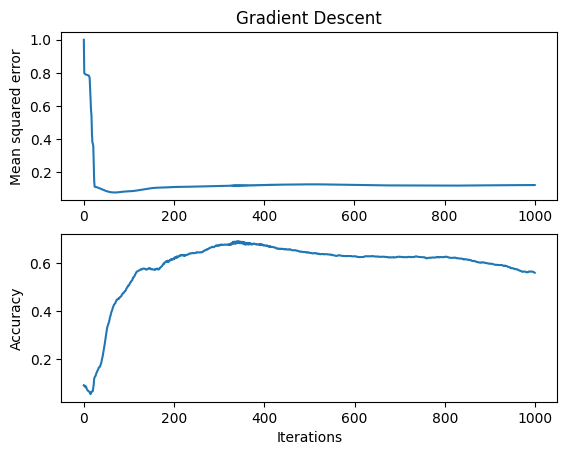

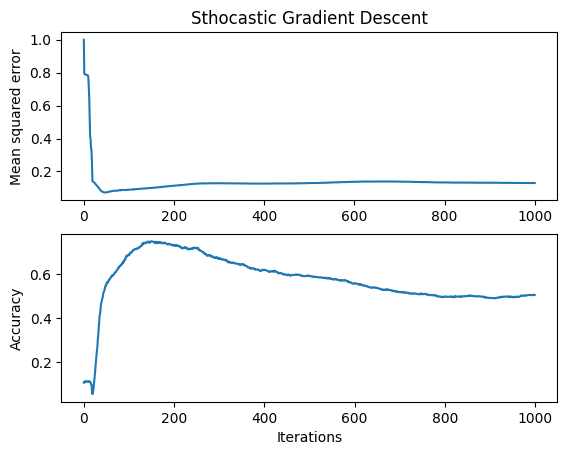

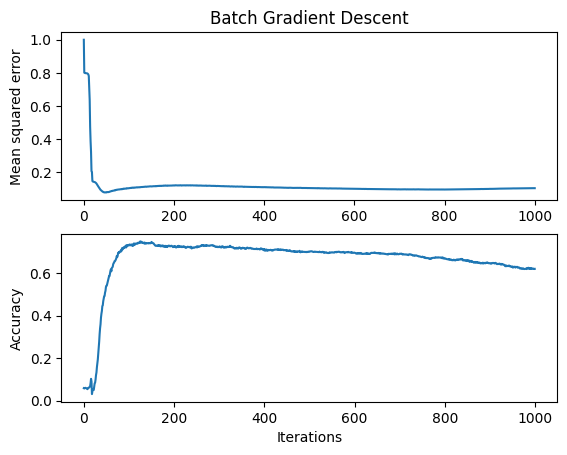

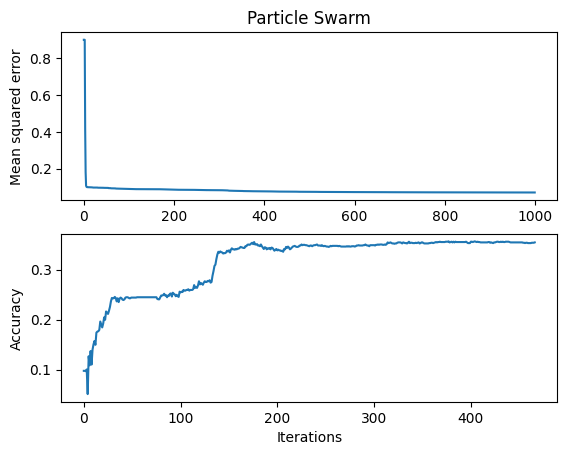

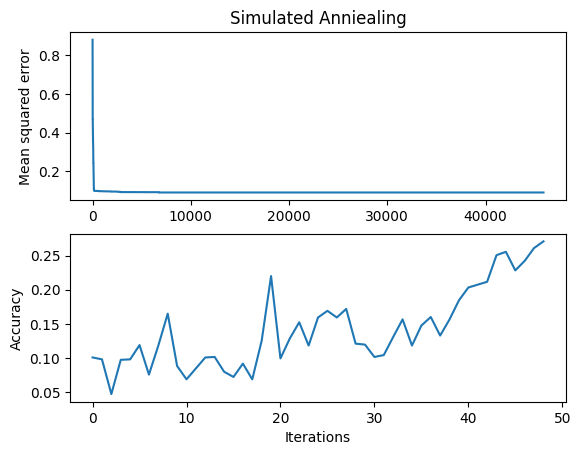

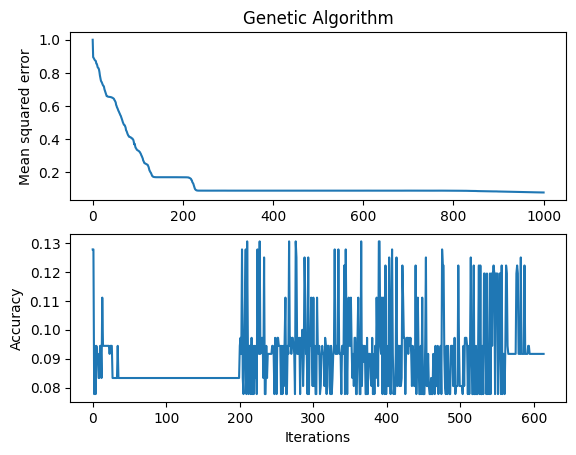

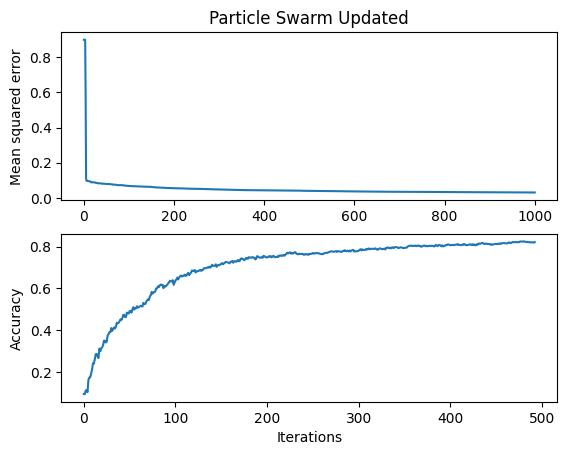

In [49]:
for key, r in RESULTS.items():
    result = r
    best_scores = result.best_scores
    accuracies = result.accuracies
    # Plot
    error = [tup[0] for tup in best_scores]
    iters = [tup[1] for tup in best_scores]
    figure = plt.figure()
    errorplot = plt.subplot(2, 1, 1,)
    errorplot.plot(error, iters)
    plt.title(key)
    plt.ylabel("Mean squared error")
    
    accuracyplot = plt.subplot(2, 1, 2)
    accuracyplot.plot(accuracies)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    
    plt.show()

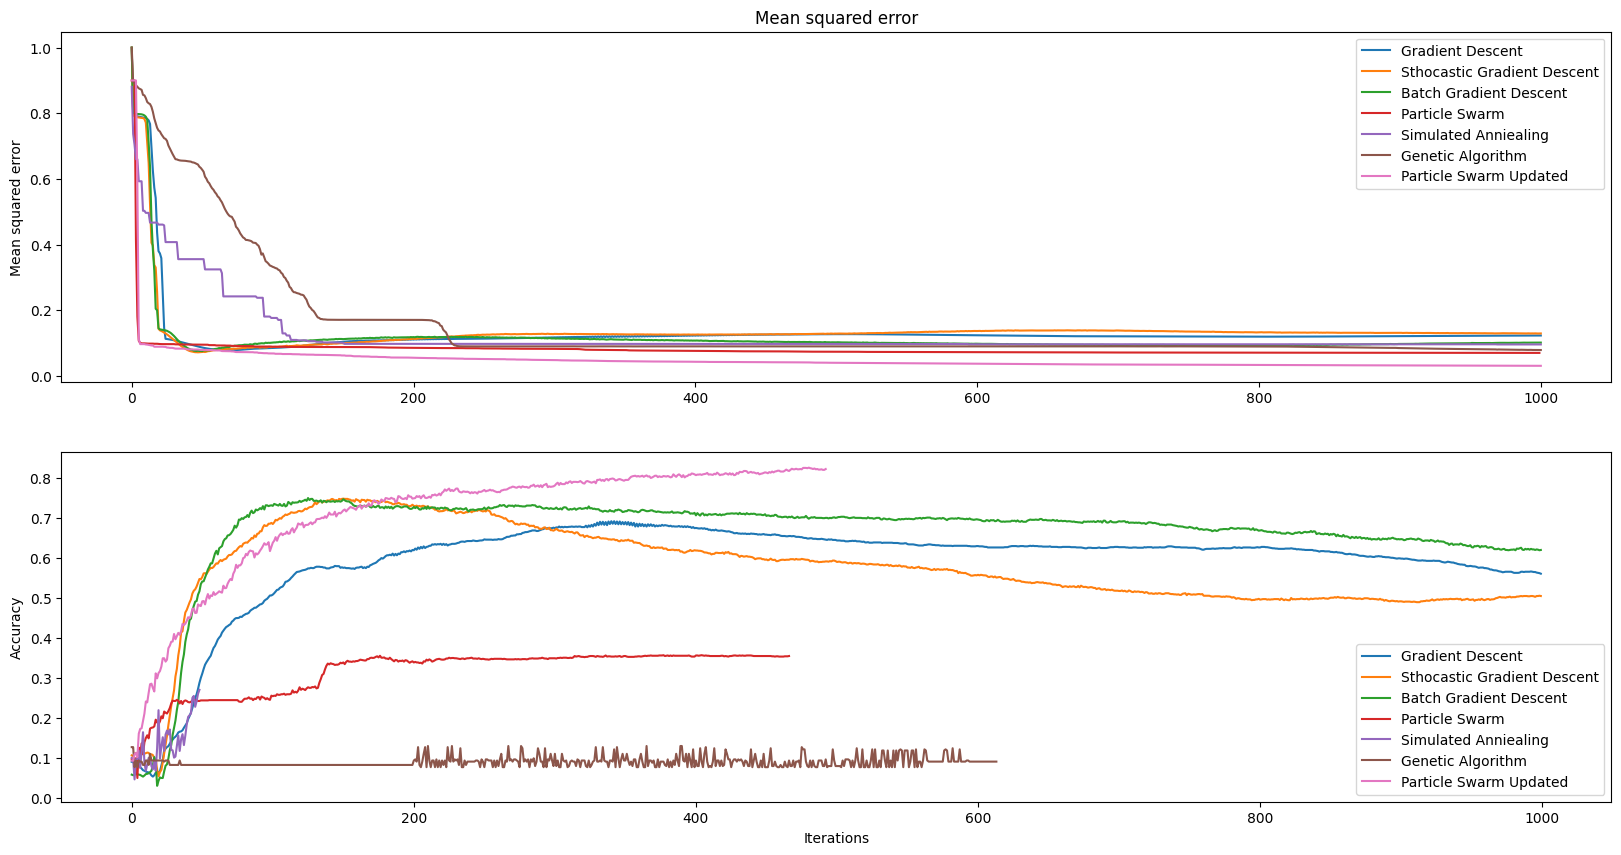

In [53]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(20, 10))

errorplot = plt.subplot(2, 1, 1,)
accuracyplot = plt.subplot(2, 1, 2)

for key, r in RESULTS.items():
    result = r
    best_scores = result.best_scores
    accuracies = result.accuracies

    # Plot
    error = [tup[0] for i, tup in enumerate(best_scores) if i <= 1000]
    iters = [tup[1] for i, tup in enumerate(best_scores) if i <= 1000]
    errorplot.plot(error, iters, label=key)

    accuracyplot.plot(accuracies, label=key)

errorplot.set_title("Mean squared error")
errorplot.set_ylabel("Mean squared error")
errorplot.legend()

accuracyplot.set_xlabel("Iterations")
accuracyplot.set_ylabel("Accuracy")
accuracyplot.legend()

plt.show()
